#### Inference + ocr + post_processing 테스트

##### 모듈 불러오기

In [1]:
import torch
import cv2
import os, io
from google.cloud import vision
from google.cloud.vision_v1 import types
import pandas as pd
import cv2
import time, datetime
from datetime import datetime
from matplotlib import pyplot as plt
import requests
import numpy as np

##### 영상처리 함수

In [2]:
# 인퍼런스 함수
def inference(img):
    try:
        # train된 weight로 yolov5 model불러오기
        # path에 weight 경로 넣어주기
        model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt')

        # inference 수행
        with torch.no_grad():
            result = model(img, 640)

        # Inference된 이미지에서 해당 영역만 추출
        crop = result.crop(save=False)

        # memory 초기화 및 캐시 삭제
        del result
        torch.cuda.empty_cache()

        return 1, crop[0]['im']

    except:
        return 0, 0

In [3]:
# 영상처리 함수(전처리)
def image_change(image):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) ## BGR 색상 이미지를 회색조 이미지로 변환
    image_blur=cv2.GaussianBlur(image_gray,ksize=(3,3),sigmaX=0) ## 가우시안블러 효과를 넣어준다.

    
    k=cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))


    erode = cv2.erode(image_blur,k) # 이미지의 빈 공간을 매꿔준다 (1)from matplotlib import pyplot as plt
    for i in range(2): 
        erode = cv2.erode(erode,k)

    opening=cv2.morphologyEx(erode,cv2.MORPH_OPEN,k) # 이미지의 빈 공간을 매꿔준다 (2)
    for i in range(2):
        opening=cv2.morphologyEx(opening,cv2.MORPH_OPEN,k)

    output_img=opening

    return output_img

In [4]:
# openCV Image -> Bytes
def image_to_bts(frame):
    _, bts = cv2.imencode('.webp', frame)
    bts = bts.tostring()
    return bts

In [5]:
# 이미지 인식 함수(OCR) / (구글 API 코드) 
def detectText(img,infor=0): 

    # enroll environment variable
    os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'visionapi-345714-015c99714d2d.json' # key가 포함되어 있는 json파일

    # make client object
    client=vision.ImageAnnotatorClient()

    # image -> bytes -> ocr image
    content=image_to_bts(img)
    image=types.Image(content=content)

    # text detection and recognition 
    response=client.text_detection(image=image)
    texts=response.text_annotations

    if infor:
        # print text_annotation 
        for idx,text in enumerate(texts):
            print('{}) {}'.format(idx+1,text.description))
            vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])
            print('bounds: {}\n'.format(','.join(vertices)))

    # make list with description
    list=[]
    for text in texts:
        list.append(text.description)

    return list

In [6]:
# 후처리 함수 (yyyy-mm-dd) 
def result_word(str_input,infor=0):
    if infor:
        print("입력:{}".format(str_input))

    date=[]
    number=[]
    
    try:  
        for i in range(0,len(str_input),1): # 문장에 있는 단어를 하나하나 검사하면서 0,1,2,3,4,5,6,7,8,9에 포함 되면 해당단어가 리스트에 추가된다.
                 if (str_input[i]=='0' or
                     str_input[i]=='1' or 
                     str_input[i]=='2' or 
                     str_input[i]=='3' or 
                     str_input[i]=='4' or 
                     str_input[i]=='5' or
                     str_input[i]=='6' or
                     str_input[i]=='7' or
                     str_input[i]=='8' or
                     str_input[i]=='9'):
                
                     number.append(str_input[i]) 
                        
        if len(number)==8: # yyyy mm dd일 경우
                year="".join(number[0:4])
                month="".join(number[4:6])
                day="".join(number[6:8])
                
                return "{0}-{1}-{2}".format(year,month,day) # yyyy-mm-dd 형식에 맞춰서 반환
                
        elif len(number)==6: # yy mm dd일 경우
                year="".join(number[0:2])

                month="".join(number[2:4])
                day="".join(number[4:6])
                
                return "20{0}-{1}-{2}".format(year,month,day) # yyyy-mm-dd 형식에 맞춰서 반환

        elif len(number)==4: # mm dd일 경우
                month="".join(number[0:2])
                day="".join(number[2:4])
                return "{0}-{1}-{2}".format(datetime.today().year,month,day) # yyyy-mm-dd 형식에 맞춰서 반환

        else:
                return 0

    except:
        return 0

In [7]:
# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(20,20))
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

##### 단계별로 확인

In [8]:
# 파일 이름 및 경로 설정
FILE_NAME='안성현(0).jpg' 
FOLDER_PATH="pictures" 
FILE_PATH=os.path.join(FOLDER_PATH, FILE_NAME)

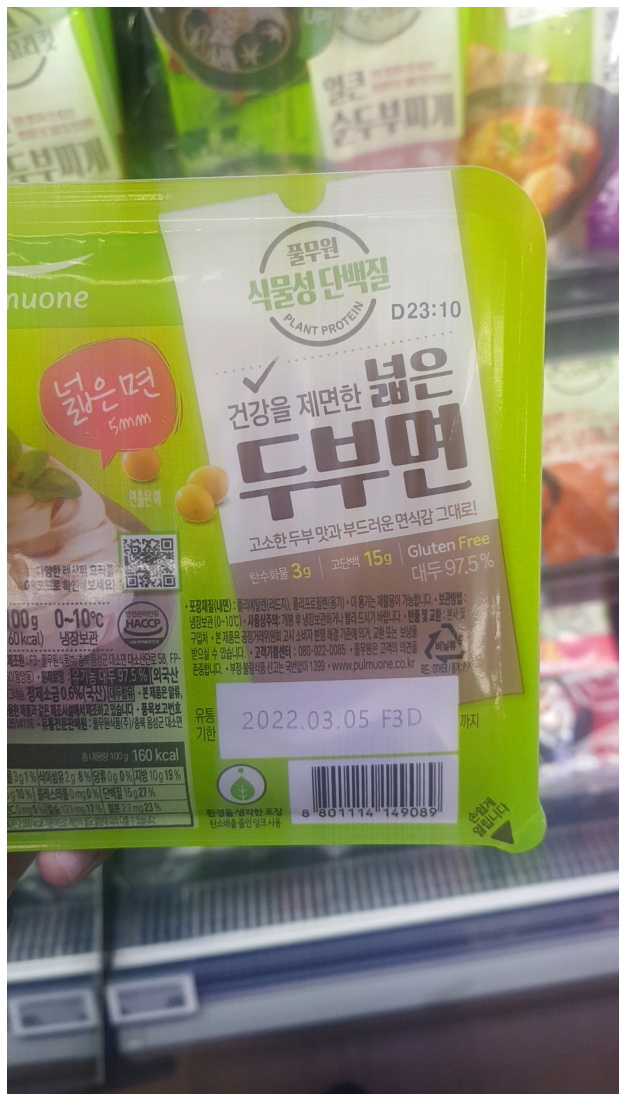

In [9]:
# 이미지 객체 생성 및 확인 
org_img=cv2.imread(FILE_PATH)
imshow(org_img)

Using cache found in /home/ahnsunghyun/.cache/torch/hub/ultralytics_yolov5_master
fatal: (현재 폴더 또는 상위 폴더 중 일부가) 깃 저장소가 아닙니다: .git
YOLOv5 🚀 2022-4-3 torch 1.8.2+cu111 CUDA:0 (NVIDIA GeForce RTX 2060, 5926MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/tmp/ipykernel_125480/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


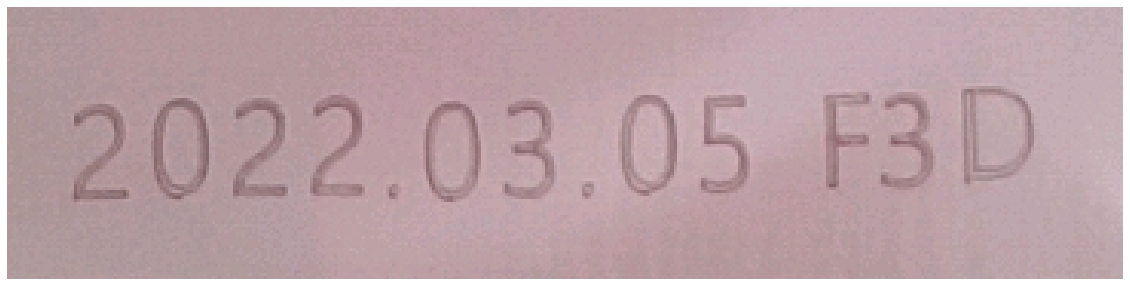

In [10]:
# 인퍼런스 함수 호출
s,img=inference(org_img)

if s:
    imshow(img)
else:
    print("can't find!!")

/tmp/ipykernel_125480/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


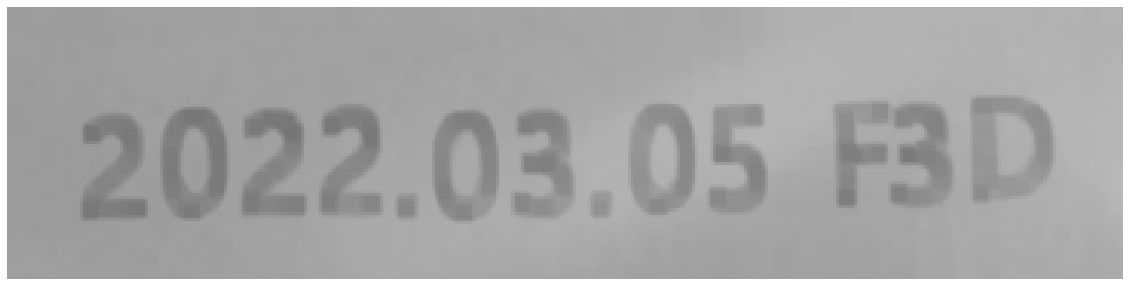

In [11]:
# 영상 전처리 함수 호출
pre_img=image_change(img) 
imshow(pre_img)

In [12]:
# OCR 함수 호출
ocr_text_list=detectText(pre_img,1)
print(ocr_text_list)

/tmp/ipykernel_125480/1923968608.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bts = bts.tostring()


1) 2022.03.05 F3D

bounds: (23,28),(341,28),(341,71),(23,71)

2) 2022.03.05
bounds: (23,32),(247,28),(248,67),(24,71)

3) F3D
bounds: (270,30),(340,29),(341,64),(271,65)

['2022.03.05 F3D\n', '2022.03.05', 'F3D']


In [13]:
# 텍스트 처리 함수 호출
print(result_word(ocr_text_list[1],1)) 

입력:2022.03.05
2022-03-05


##### 한 번에 확인 (+ 시간 체크)

/tmp/ipykernel_125480/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Using cache found in /home/ahnsunghyun/.cache/torch/hub/ultralytics_yolov5_master
fatal: (현재 폴더 또는 상위 폴더 중 일부가) 깃 저장소가 아닙니다: .git
YOLOv5 🚀 2022-4-3 torch 1.8.2+cu111 CUDA:0 (NVIDIA GeForce RTX 2060, 5926MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/tmp/ipykernel_125480/1923968608.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bts = bts.tostring()


['2022.03.05 F3D\n', '2022.03.05', 'F3D']
2022-03-05
소요 시간: 1.34초


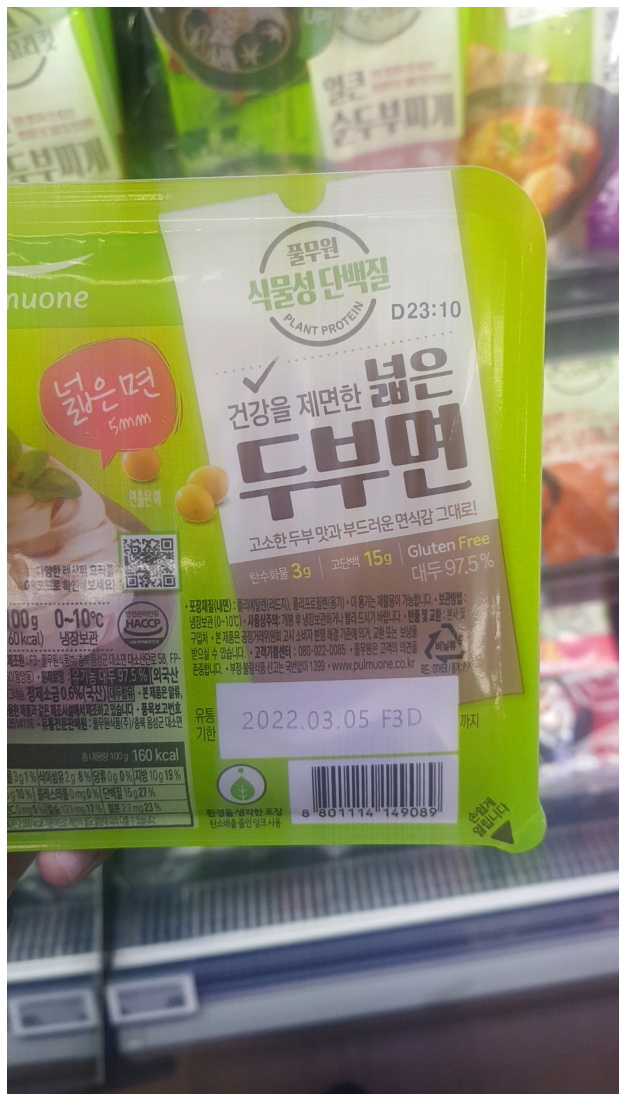

In [14]:
# 파일 이름 및 경로 설정
FILE_NAME='안성현(0).jpg' 
FOLDER_PATH="pictures" 
FILE_PATH=os.path.join(FOLDER_PATH, FILE_NAME)

# 원본 영상 확인
org_img=cv2.imread(FILE_PATH)
imshow(org_img)

start = time.time() # << 시간 측정 시작 >>

# 인퍼런스 함수 호출
s, img=inference(org_img)

if s:
    # 영상 전처리 함수 호출
    pre_img=image_change(img) 

    # OCR 함수 호출
    ocr_text_list=detectText(pre_img)
    print(ocr_text_list)

    # 텍스트 처리 함수 호출
    result = result_word(ocr_text_list[1])

    # OCR 성공 시 출력
    if result:
        print(result)
    else:
        print("can't find!!")

else:
    print("can't find!!")

end = time.time() # << 시간 측정 끝 >>
sec = (end - start)
print('소요 시간: {:.2f}초'.format(sec))

##### 카카오 이미지 URL -> OCR

In [15]:
def url2img(url):
    _url = url 
    image_nparray = np.asarray(bytearray(requests.get(_url).content),
                               dtype=np.uint8)  # 전처리 (url image -> nparray)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)  # 전처리 (nparray -> cv2 image)
    return image

/tmp/ipykernel_125480/1527593960.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Using cache found in /home/ahnsunghyun/.cache/torch/hub/ultralytics_yolov5_master
fatal: (현재 폴더 또는 상위 폴더 중 일부가) 깃 저장소가 아닙니다: .git
YOLOv5 🚀 2022-4-3 torch 1.8.2+cu111 CUDA:0 (NVIDIA GeForce RTX 2060, 5926MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/tmp/ipykernel_125480/1923968608.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bts = bts.tostring()


2021-12-22


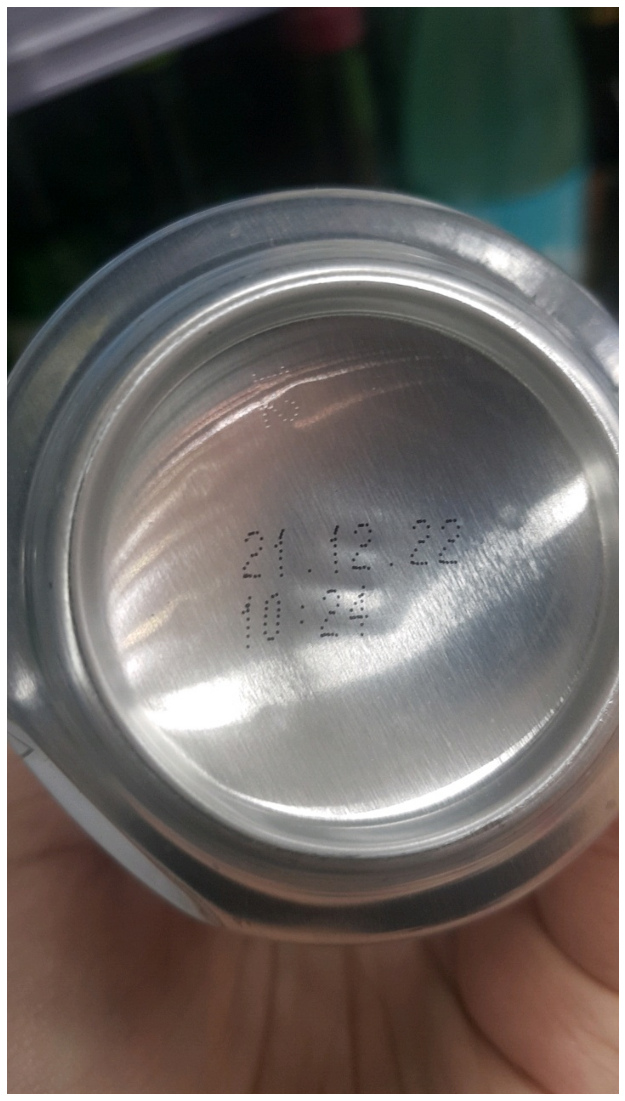

In [16]:
addr='http://dn-m.talk.kakao.com/talkm/bl4ZifApwDM/HmuHtsvocsNvS5jAEQHZv1/i_dcfdb85186b9.jpg'
org_img=url2img(addr)
imshow(org_img)

s,img=inference(org_img)

if s:
    pre_img=image_change(img) 
    ocr_text_list=detectText(pre_img)
    result = result_word(ocr_text_list[1])

    if result:
        print(result)
    else:
        print("can't find!!")

else:
    print("can't find!!")